In [4]:
import numpy as np                                                  
import pandas as pd       
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import folium

In [5]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

In [11]:
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [10]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [12]:
sample = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


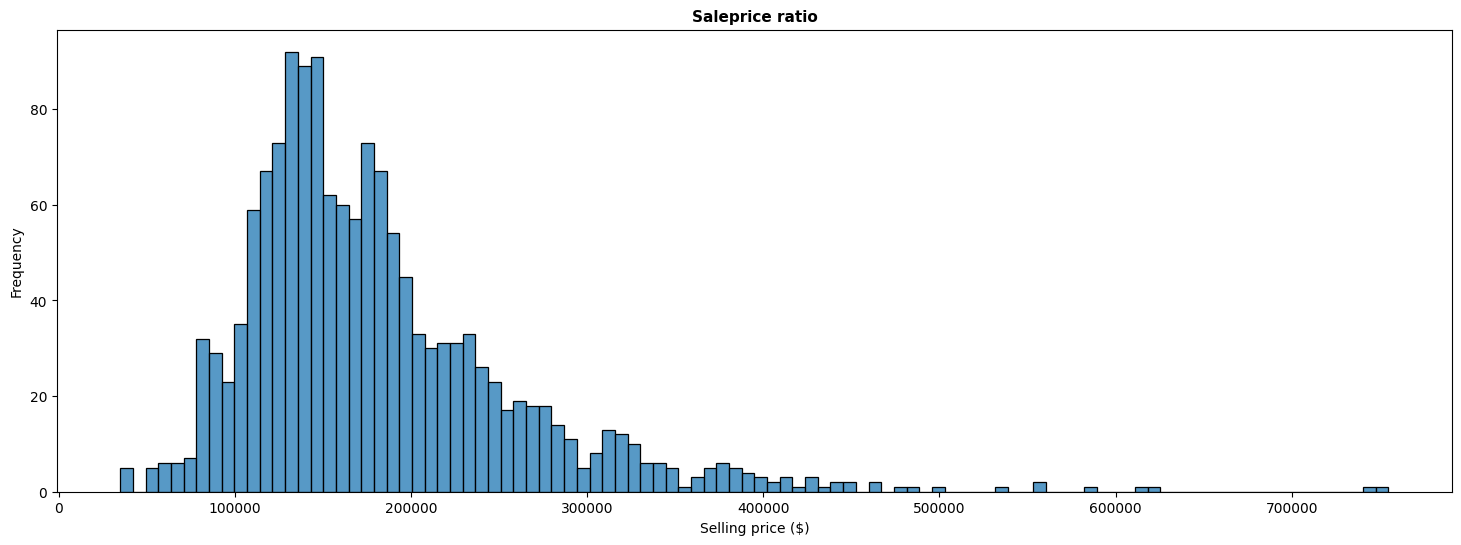

In [14]:
plt.figure(figsize=(18, 6))                                                                    
sns.histplot(train['SalePrice'], bins=100)                                                     
plt.xlabel('Selling price ($)')                                                   
plt.ylabel('Frequency')                                                           
plt.title('Saleprice ratio', fontdict={'fontsize': 11, 'fontweight': 'bold'})                  
plt.show()                                                                                                                                            

In [15]:
print(train['SalePrice'].describe())    

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [18]:
columns_to_impute_train = []
columns_to_remove_train = []

columns_to_impute_test = []
columns_to_remove_test = []

for column in train.columns:                                                       
    null_count = train[column].isnull().sum()                                      
    if null_count >= 500:                                                          
        columns_to_remove_train.append(column)
    elif null_count >= 1:                                                          
        columns_to_impute_train.append(column)
    else:                                                                          
        pass

for column in test.columns:                                                        
    null_count = test[column].isnull().sum()
    if null_count >= 500:
        columns_to_remove_test.append(column)
    elif null_count >= 1:
        columns_to_impute_test.append(column)
    else:
        pass

print("Columns to impute in train ", columns_to_impute_train, '\n')
print("Columns to remove in train: ", columns_to_remove_train, '\n')

print("Columns to impute in test: ", columns_to_impute_test, '\n')
print("Columns to remove in test: ", columns_to_remove_test)

Columns to impute in train  ['LotFrontage', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond'] 

Columns to remove in train:  ['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'] 

Columns to impute in test:  ['MSZoning', 'LotFrontage', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'SaleType'] 

Columns to remove in test:  ['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


In [19]:
train_clean = train.drop(columns_to_remove_train, axis=1)                                   # We get rid of the series we are not interested in and store them in a new variable.
test_clean = test.drop(columns_to_remove_test, axis=1)                                      # We repeat with the test dataset
print("No. of columns:",train_clean.shape[1]," - vs - ", train.shape[1])

No. of columns: 75  - vs -  81


In [20]:
cat_columns_train = train_clean.select_dtypes(include=['object'])                          # In the same way we will isolate all series with categorical data.
cat_columns_test = test_clean.select_dtypes(include=['object'])                            

print(cat_columns_train.columns)

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'SaleType', 'SaleCondition'],
      dtype='object')


In [21]:
label_encoder = LabelEncoder()                                                             
for i in cat_columns_train.columns:                                                 
    train_clean[i] = label_encoder.fit_transform(train_clean[i])               
for j in cat_columns_test.columns:
    test_clean[j] = label_encoder.fit_transform(test_clean[j])
train_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   int64  
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   int64  
 6   LotShape       1460 non-null   int64  
 7   LandContour    1460 non-null   int64  
 8   Utilities      1460 non-null   int64  
 9   LotConfig      1460 non-null   int64  
 10  LandSlope      1460 non-null   int64  
 11  Neighborhood   1460 non-null   int64  
 12  Condition1     1460 non-null   int64  
 13  Condition2     1460 non-null   int64  
 14  BldgType       1460 non-null   int64  
 15  HouseStyle     1460 non-null   int64  
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [32]:
knn_imputer_train = KNNImputer(n_neighbors=5, metric='nan_euclidean')                                           # We create an imputer that selects the 5 closest ones and apply an ecludian distance.
knn_imputer_train.fit(train_clean[columns_to_impute_train])                                                     # We train the imputer with the DS

train_clean[columns_to_impute_train] = knn_imputer_train.transform(train_clean[columns_to_impute_train])        # And apply the transformation of the series with missing data on itself


knn_imputer_test = KNNImputer(n_neighbors=5, metric='nan_euclidean')
knn_imputer_test.fit(test_clean[columns_to_impute_test])

test_clean[columns_to_impute_test] = knn_imputer_test.transform(test_clean[columns_to_impute_test])


print("No. of nulls in the dataset: ", train_clean.isnull().sum().sum())

No. of nulls in the dataset:  0


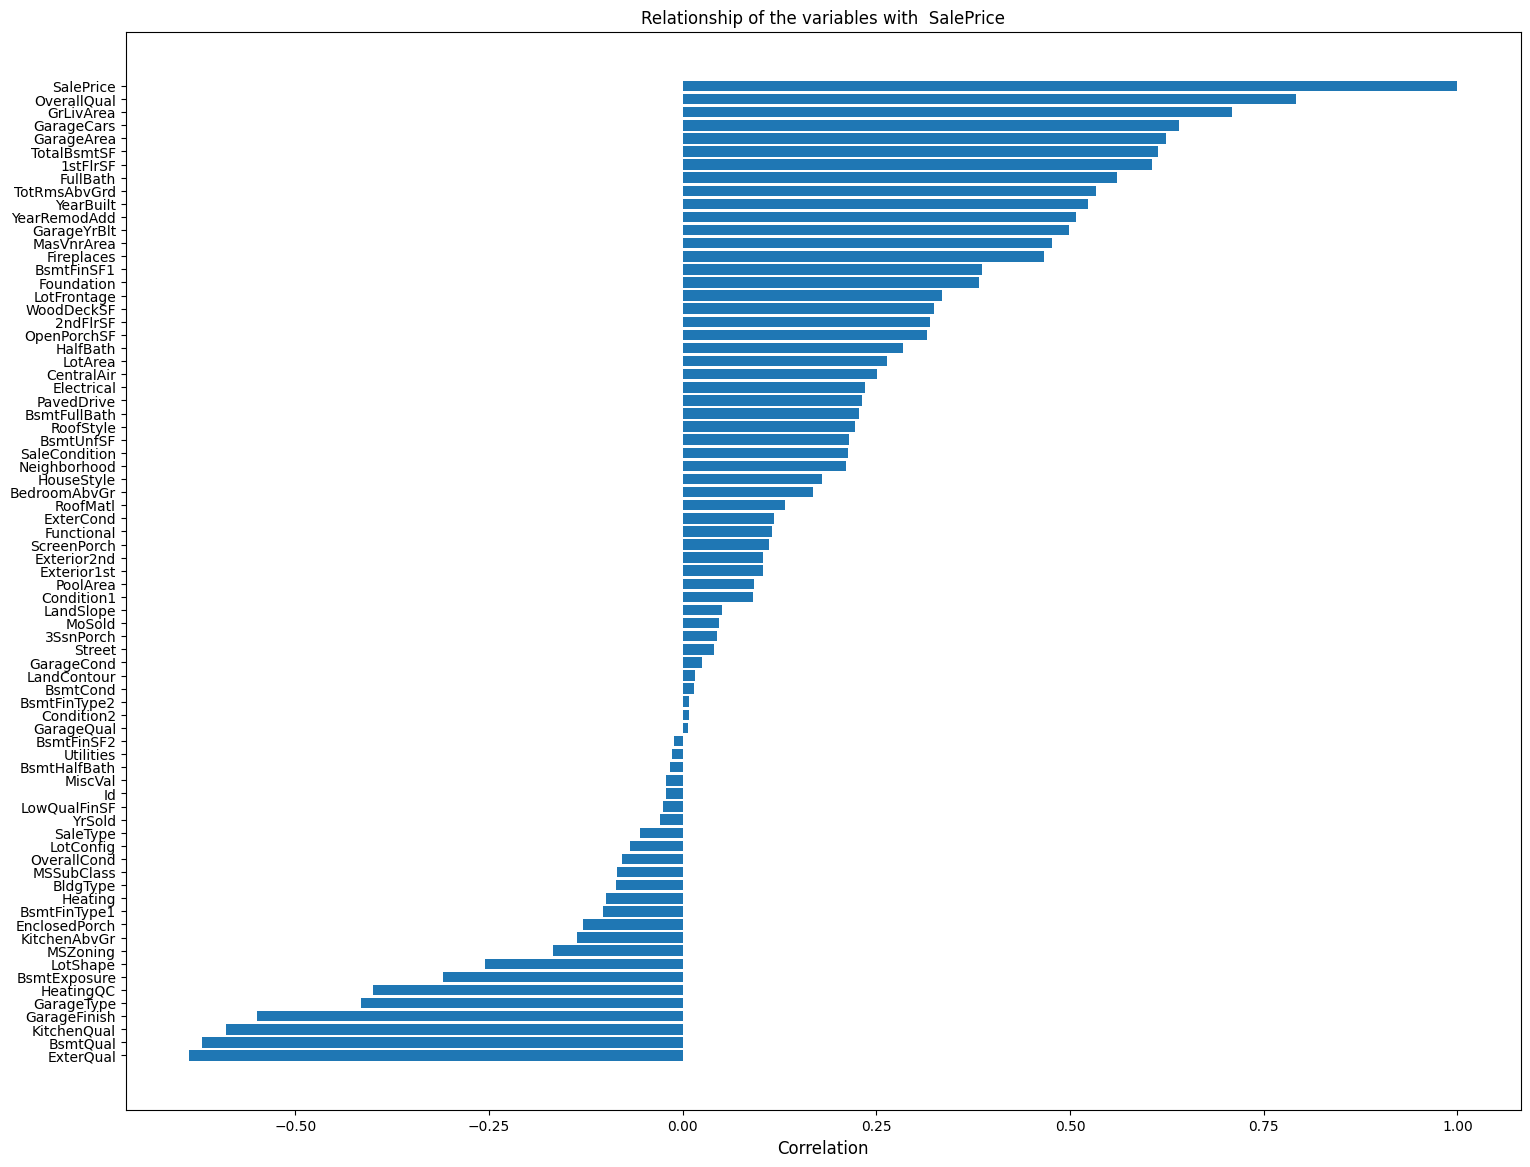

In [24]:
corr = train_clean.corr()                                               
corr_sale = corr['SalePrice'].sort_values(ascending=False)              

plt.figure(figsize=(18, 14))                                            

plt.barh(corr_sale.index, corr_sale.values)                             
plt.xlabel("Correlation", size=12)
plt.ylabel("")
plt.title("Relationship of the variables with  SalePrice")
plt.gca().invert_yaxis()                                                

plt.show()

In [33]:
train_clean.info()
train_clean.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   int64  
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   int64  
 6   LotShape       1460 non-null   int64  
 7   LandContour    1460 non-null   int64  
 8   Utilities      1460 non-null   int64  
 9   LotConfig      1460 non-null   int64  
 10  LandSlope      1460 non-null   int64  
 11  Neighborhood   1460 non-null   int64  
 12  Condition1     1460 non-null   int64  
 13  Condition2     1460 non-null   int64  
 14  BldgType       1460 non-null   int64  
 15  HouseStyle     1460 non-null   int64  
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,3.028767,70.070685,10516.828082,0.995890,1.942466,2.777397,0.000685,3.019178,...,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,7.513014,3.770548,180921.195890
std,421.610009,42.300571,0.632017,22.658398,9981.264932,0.063996,1.409156,0.707666,0.026171,1.622634,...,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,1.552100,1.100854,79442.502883
min,1.000000,20.000000,0.000000,21.000000,1300.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,0.000000,0.000000,34900.000000
25%,365.750000,20.000000,3.000000,60.000000,7553.500000,1.000000,0.000000,3.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,8.000000,4.000000,129975.000000
50%,730.500000,50.000000,3.000000,70.000000,9478.500000,1.000000,3.000000,3.000000,0.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,8.000000,4.000000,163000.000000
75%,1095.250000,70.000000,3.000000,80.000000,11601.500000,1.000000,3.000000,3.000000,0.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,8.000000,4.000000,214000.000000
max,1460.000000,190.000000,4.000000,313.000000,215245.000000,1.000000,3.000000,3.000000,1.000000,4.000000,...,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,8.000000,5.000000,755000.000000


In [29]:
# ames_map = folium.Map(location=[42.0308, -93.6319], zoom_start=14)
# ames_map

In [27]:
street_count = train['Street'].value_counts()
print(street_count)

Street
Pave    1454
Grvl       6
Name: count, dtype: int64


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


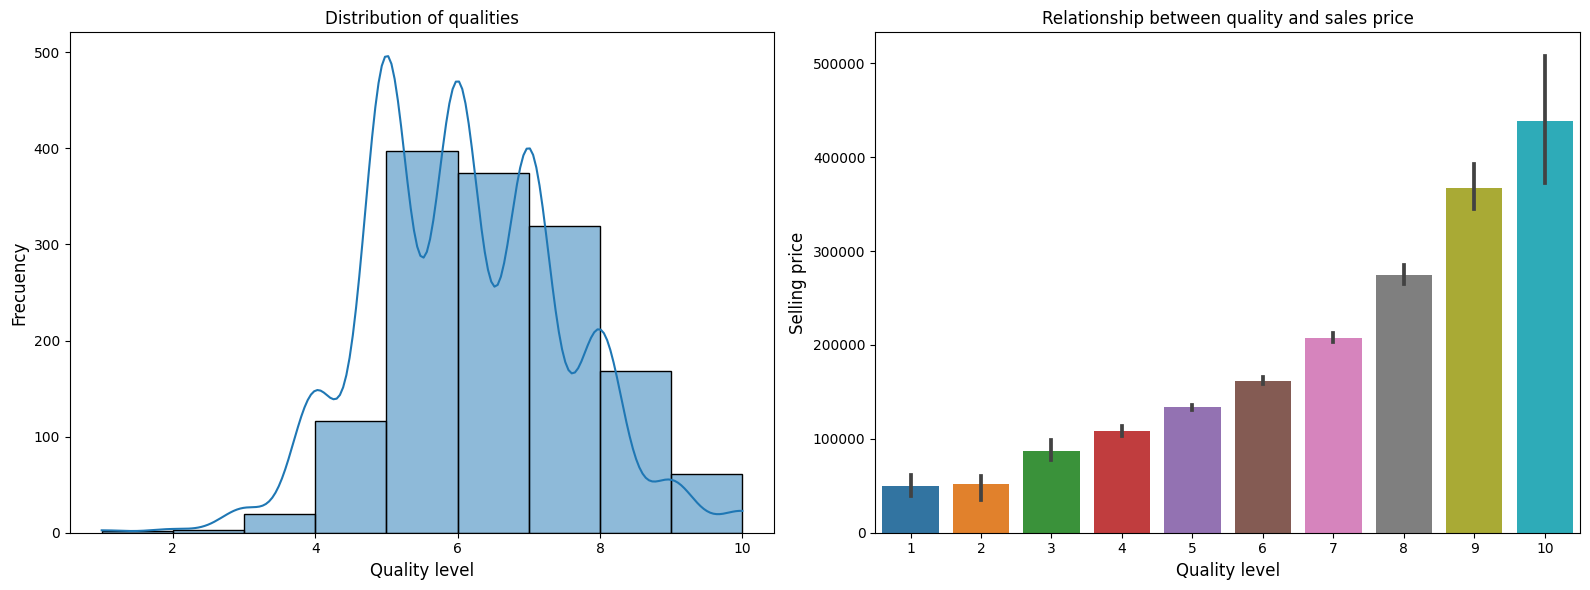

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))                                                                  # We create a grid for two graphs and give it size.

sns.histplot(data=train_clean, x='OverallQual', ax=axes[0], bins=range(1, 11), kde=True)                         # We create a histiogram with the OverallQual data indicating position, intervals and trend line.
axes[0].set_xlabel('Quality level', size=12)
axes[0].set_ylabel('Frecuency', size=12)
axes[0].set_title('Distribution of qualities')

sns.barplot(data=train_clean, x='OverallQual', y='SalePrice', ax=axes[1])                                        # We create a bar chart with the OverallQual vs SalePrice data and indicate its position.
axes[1].set_xlabel('Quality level', size=12) 
axes[1].set_ylabel('Selling price', size=12)
axes[1].set_title('Relationship between quality and sales price')

plt.tight_layout()
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


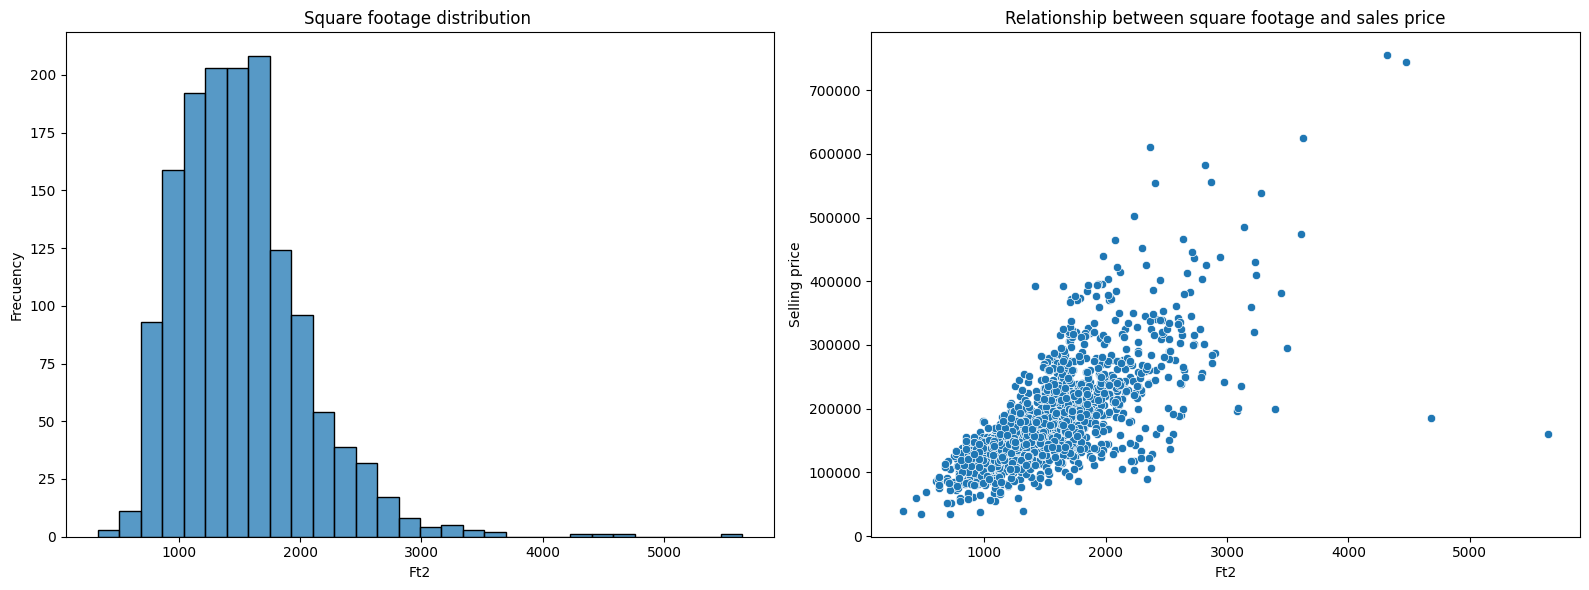

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(data=train_clean, x='GrLivArea', ax=axes[0], bins=30)                                       # We create a histiogram with the variable GrLivArea, intervals and trend line.
axes[0].set_xlabel('Ft2')
axes[0].set_ylabel('Frecuency')
axes[0].set_title('Square footage distribution ')

sns.scatterplot(data=train_clean, x='GrLivArea', y='SalePrice', ax=axes[1])                                        # We create a scatter plot of GrLivArea data by SalePrice data.      
axes[1].set_xlabel('Ft2')
axes[1].set_ylabel('Selling price')
axes[1].set_title('Relationship between square footage and sales price')

plt.tight_layout()
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


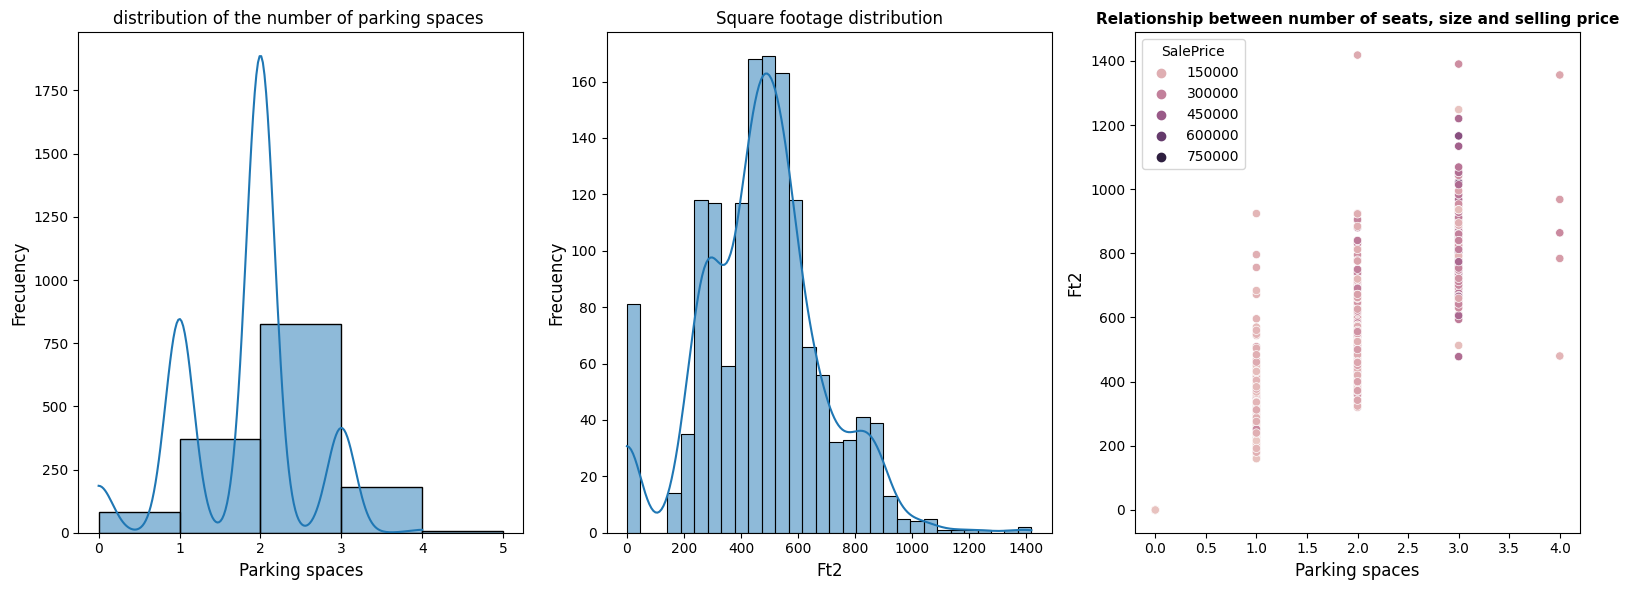

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))                                                                   # We create a grid for three charts

sns.histplot(data=train_clean, x='GarageCars', ax=axes[0], bins=range(6), kde=True)                               # We create a histiogram with the variable GarageCars, intervals and trend line.
axes[0].set_xlabel('Parking spaces', size=12)
axes[0].set_ylabel('Frecuency', size=12)
axes[0].set_title('distribution of the number of parking spaces ')

sns.histplot(data=train_clean, x='GarageArea', ax=axes[1], bins=30, kde=True)                                     # We create a histiogram with the variable GarageArea, intervals and trend line. 
axes[1].set_xlabel('Ft2', size=12)
axes[1].set_ylabel('Frecuency', size=12)
axes[1].set_title('Square footage distribution')
sns.scatterplot(data=train_clean, x='GarageCars', y='GarageArea', hue='SalePrice', ax=axes[2])                    # We create a scatter plot of the GaraageCars and GarageArea data by SalePrice data.
axes[2].set_xlabel('Parking spaces', size=12)
axes[2].set_ylabel('Ft2', size=12)
axes[2].set_title('Relationship between number of seats, size and selling price', size=11, weight='bold')
plt.tight_layout()
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


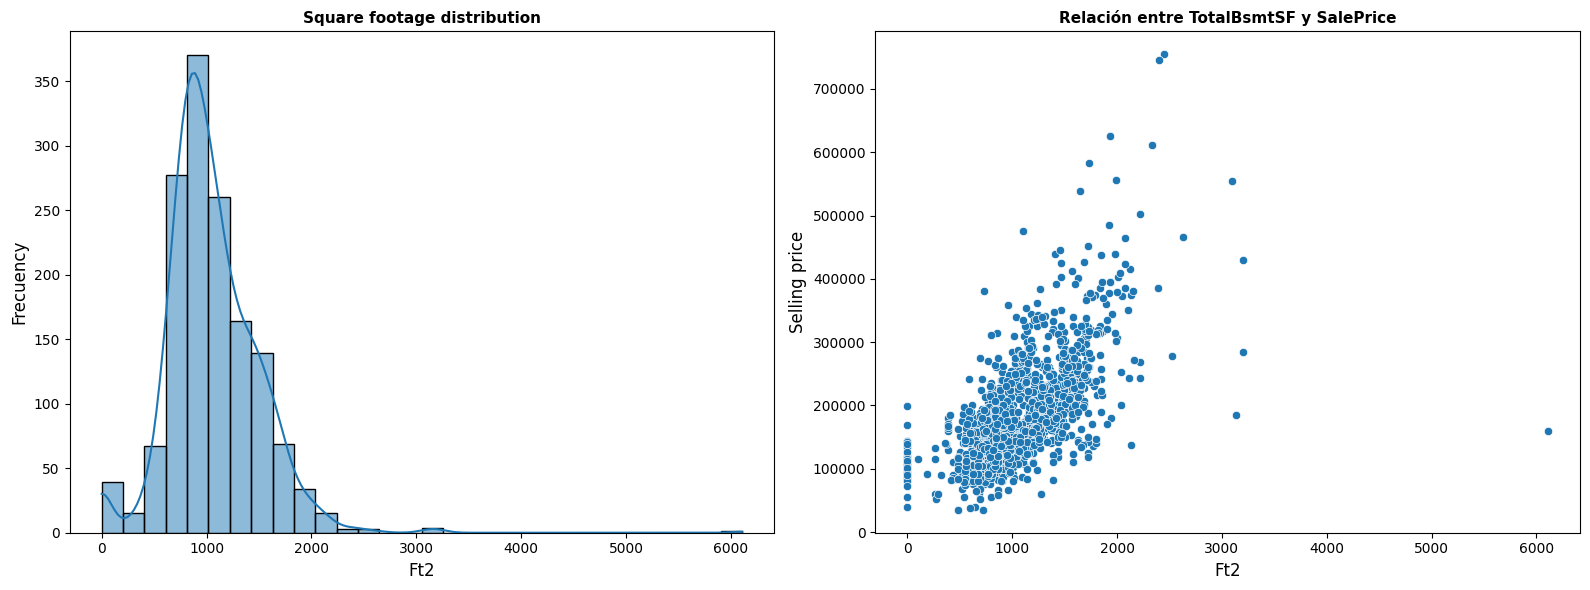

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(data=train_clean, x='TotalBsmtSF', ax=axes[0], bins=30, kde=True)                                    # We create a histiogram with the variable TotalBsmtSF, intervals and trend line.
axes[0].set_xlabel('Ft2', size=12)
axes[0].set_ylabel('Frecuency', size=12)
axes[0].set_title('Square footage distribution', size=11, weight='bold')

sns.scatterplot(data=train_clean, x='TotalBsmtSF', y='SalePrice', ax=axes[1])                                     # # We create a scatter plot of TotalBsmtSF by SalePrice data.
axes[1].set_xlabel('Ft2', size=12)
axes[1].set_ylabel('Selling price', size=12)
axes[1].set_title('Relación entre TotalBsmtSF y SalePrice', size=11, weight='bold')

plt.tight_layout()
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


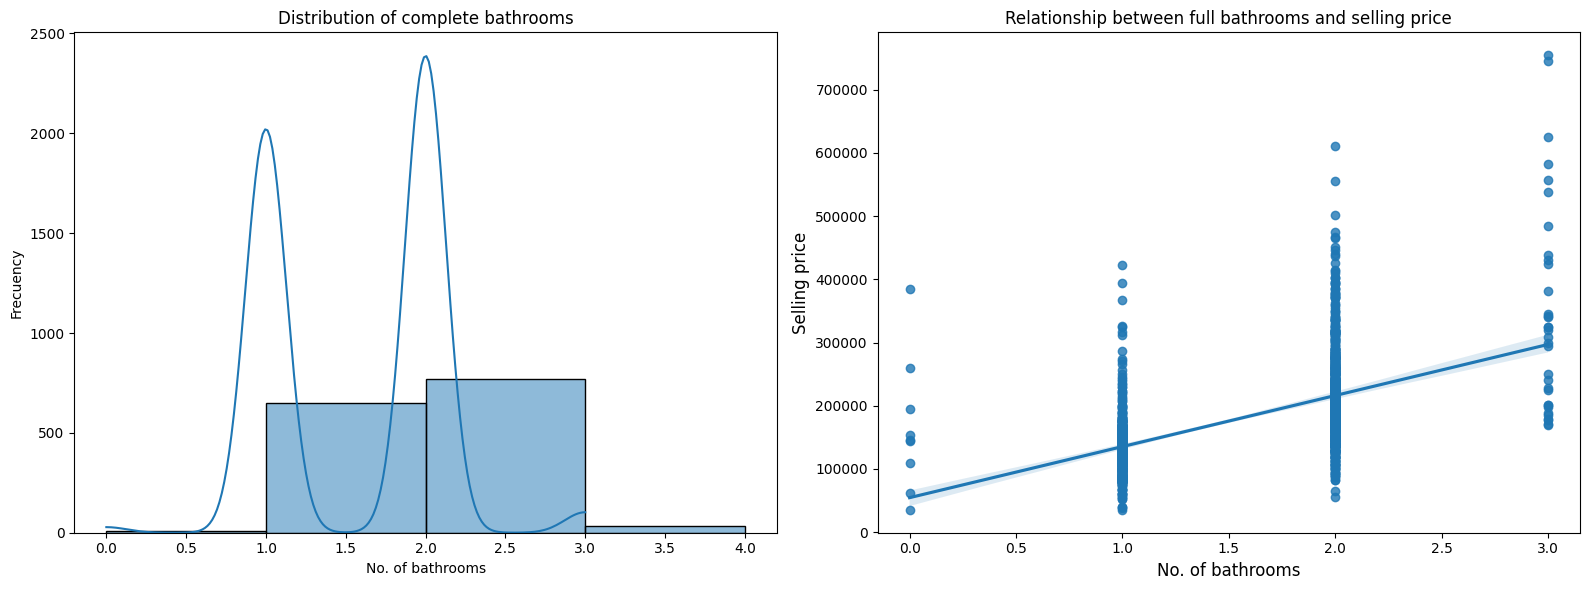

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(data=train_clean,  x='FullBath', ax=axes[0], bins=range(5), kde=True)
axes[0].set_xlabel('No. of bathrooms')
axes[0].set_ylabel('Frecuency')
axes[0].set_title('Distribution of complete bathrooms')

sns.regplot(data=train_clean, x='FullBath', y='SalePrice', ax=axes[1])
axes[1].set_xlabel('No. of bathrooms', size=12)
axes[1].set_ylabel('Selling price', size=12)
axes[1].set_title('Relationship between full bathrooms and selling price')

plt.tight_layout()
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


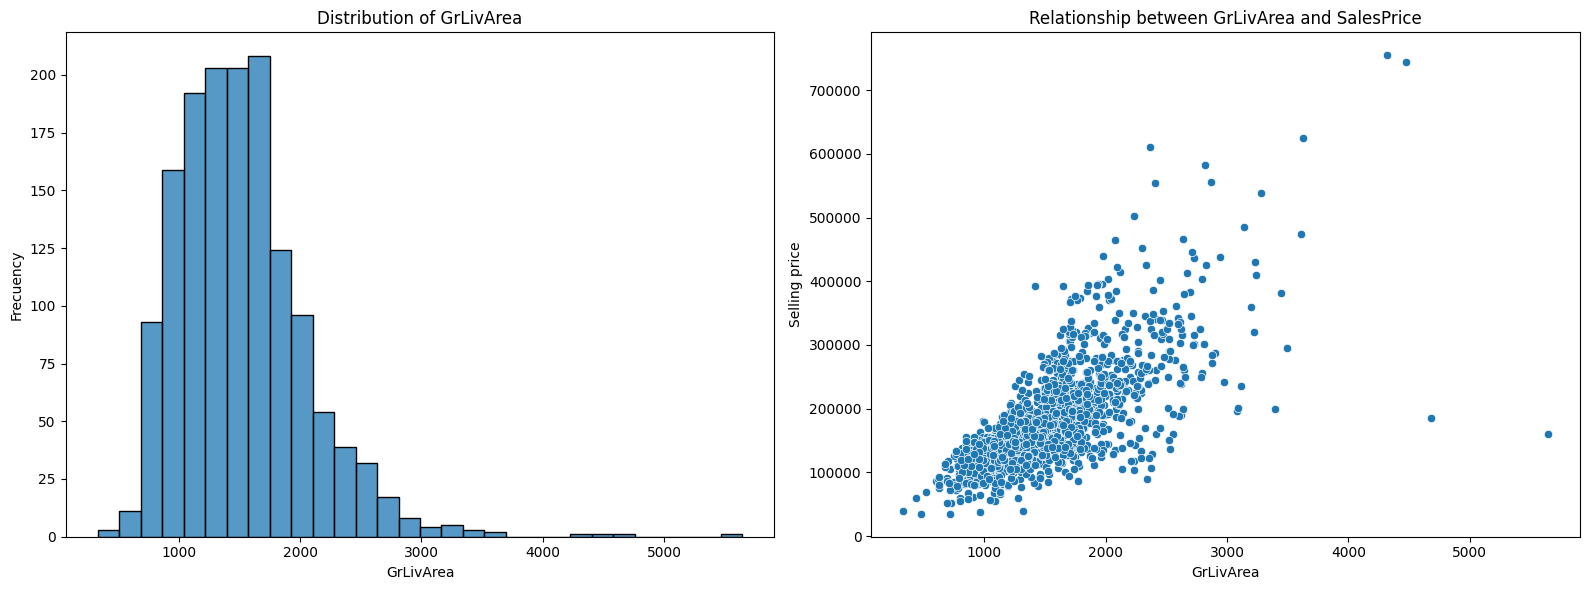

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(data=train_clean,  x='GrLivArea', ax=axes[0], bins=30)
axes[0].set_xlabel('GrLivArea')
axes[0].set_ylabel('Frecuency')
axes[0].set_title('Distribution of GrLivArea')

sns.scatterplot(data=train_clean, x='GrLivArea', y='SalePrice', ax=axes[1])
axes[1].set_xlabel('GrLivArea')
axes[1].set_ylabel('Selling price')
axes[1].set_title('Relationship between GrLivArea and SalesPrice')

plt.tight_layout()
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


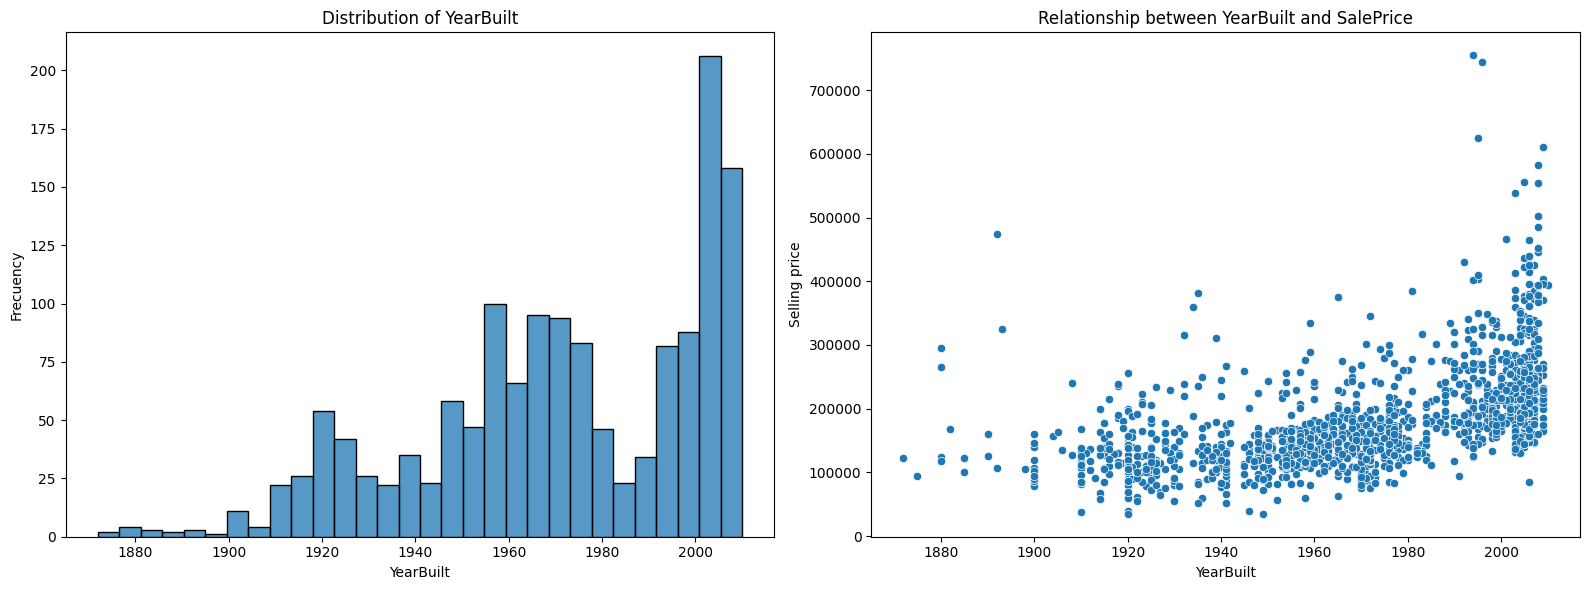

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(data=train_clean, x='YearBuilt', ax=axes[0], bins=30)
axes[0].set_xlabel('YearBuilt')
axes[0].set_ylabel('Frecuency')
axes[0].set_title('Distribution of YearBuilt')

sns.scatterplot(data=train_clean, x='YearBuilt', y='SalePrice', ax=axes[1])
axes[1].set_xlabel('YearBuilt')
axes[1].set_ylabel('Selling price')
axes[1].set_title('Relationship between YearBuilt and SalePrice')

plt.tight_layout()
plt.show()

In [47]:
x_train = train_clean[['OverallQual']]
y_train = train_clean['SalePrice']
x_test = test_clean[['OverallQual']]

In [48]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
pred = lr_model.predict(x_test)
rmse_simple = np.sqrt(mean_squared_error(y_train, lr_model.predict(x_train)))
r2_simple = r2_score(y_train, lr_model.predict(x_train))

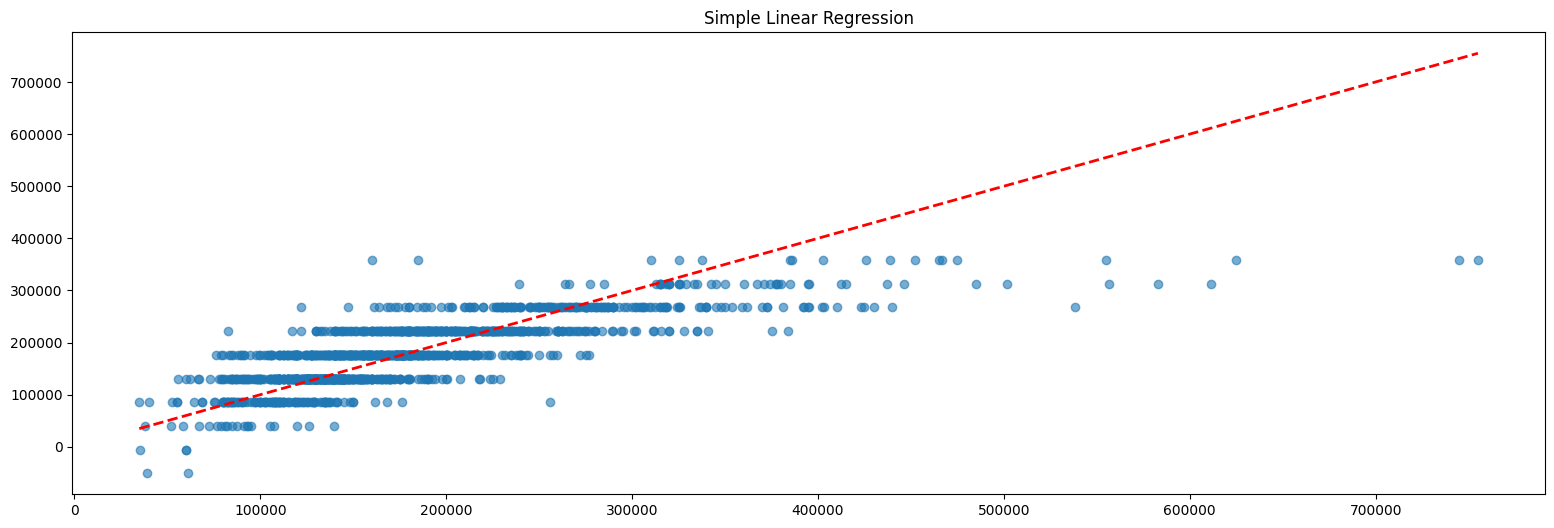

Simple Linear Regression RMSE: 48589.44712143806
Simple Linear Regression  R-squared: 0.625651892462118


In [49]:
plt.figure(figsize=(19, 6))
plt.scatter(y_train, lr_model.predict(x_train), alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('')
plt.ylabel('')
plt.title('Simple Linear Regression')
plt.show()

print(f"Simple Linear Regression RMSE: {rmse_simple}")
print(f"Simple Linear Regression  R-squared: {r2_simple}")

In [52]:
x = train_clean.drop(columns=['SalePrice'])
y = train_clean['SalePrice']

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

x_train,x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(x_train, y_train)                                 

y_pred = model.predict(x_test)

test_clean_aligned = test_clean[x.columns]
test_clean_scaled = scaler.transform(test_clean_aligned)
test_predictions = model.predict(test_clean_scaled)

rmse_multiple = np.sqrt(mean_squared_error(np.log(y_test), np.log(y_pred)))
r2_multiple = r2_score(y_test, y_pred)

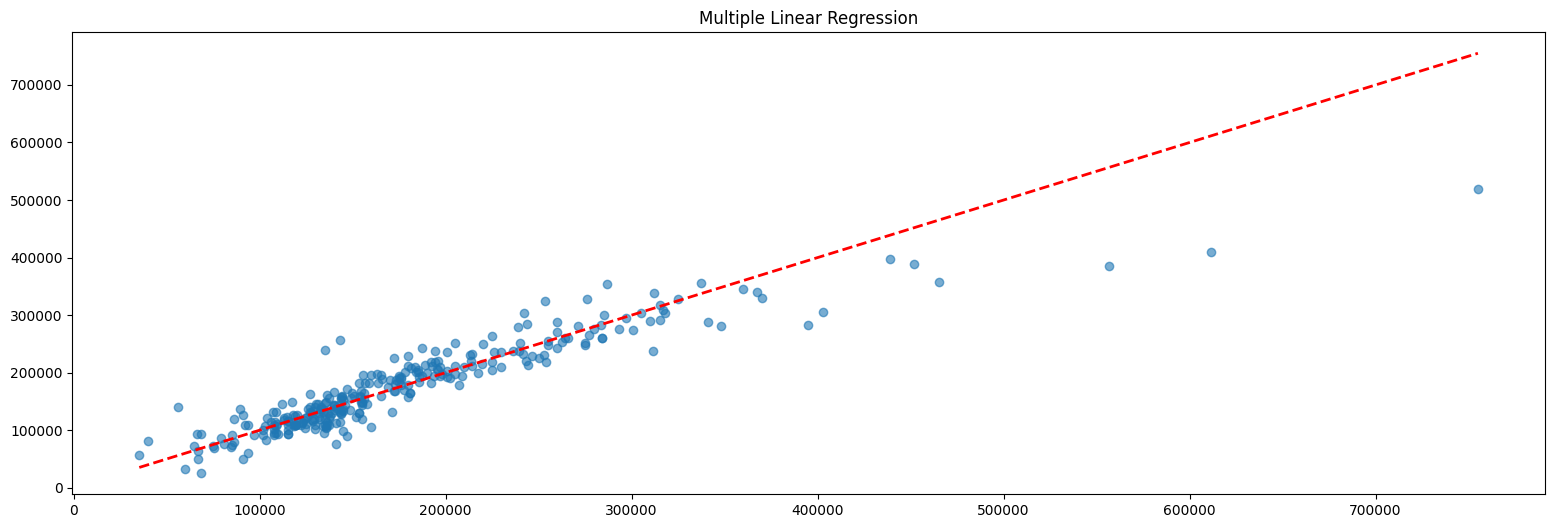

Multiple Linear Regression RMSE: 0.18666615305165168
Multiple Linear Regression R-squared: 0.8486227340014043


In [53]:
plt.figure(figsize=(19, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('')
plt.ylabel('')
plt.title('Multiple Linear Regression')
plt.show()

print(f"Multiple Linear Regression RMSE: {rmse_multiple}")
print(f"Multiple Linear Regression R-squared: {r2_multiple}")

In [54]:
ridge = Ridge()
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
ridge_grid = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(x_train, y_train)
best_ridge = ridge_grid.best_estimator_

y_pred_ridge = best_ridge.predict(x_test)
test_predictions_ridge = best_ridge.predict(test_clean_scaled)

rmse_ridge = np.sqrt(mean_squared_error(np.log(y_test), np.log(y_pred_ridge)))
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"Ridge Regression RMSE: {rmse_ridge}")
print(f"Ridge Regression R-squared: {r2_ridge}")

Ridge Regression RMSE: 0.1749492919534534
Ridge Regression R-squared: 0.8492755914886625


In [55]:
lasso = Lasso(max_iter=20000)
lasso_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
lasso_grid = GridSearchCV(lasso, lasso_params, cv=5, scoring='neg_mean_squared_error')
lasso_grid.fit(x_train, y_train)
best_lasso = lasso_grid.best_estimator_

y_pred_lasso = best_lasso.predict(x_test)
test_predictions_lasso = best_lasso.predict(test_clean_scaled)

rmse_lasso = np.sqrt(mean_squared_error(np.log(y_test), np.log(y_pred_lasso)))
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f"Lasso Regression RMSE: {rmse_lasso}")
print(f"Lasso Regression R-squarede: {r2_lasso}")

Lasso Regression RMSE: 0.18353263960290886
Lasso Regression R-squarede: 0.8482503465302562


In [57]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(x_train, y_train)

y_pred_knn = knn.predict(x_test)

knn_rmse = np.sqrt(mean_squared_error(np.log(y_test), np.log(y_pred_knn)))
knn_r2 = r2_score(y_test, y_pred_knn)

print(f"KNN Regression RMSE: {knn_rmse}")
print(f"KNN Regression R-squared: {knn_r2}")

KNN Regression RMSE: 0.20105685408538435
KNN Regression R-squared: 0.7834601888926717


In [58]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(x_train, y_train)

y_pred_rf = rf.predict(x_test)

rf_rmse = np.sqrt(mean_squared_error(np.log(y_test), np.log(y_pred_rf)))
rf_r2 = r2_score(y_test, y_pred_rf)

print(f"Random Forest RMSE: {rf_rmse}")
print(f"Random Forest R-squared: {rf_r2}")

Random Forest RMSE: 0.15420551148130945
Random Forest R-squared: 0.8924144189682909


In [59]:
results_df = pd.DataFrame({
    'Model': [
        'Simple Linear Regression', 
        'Multiple Linear Regression', 
        'Ridge Regression', 
        'Lasso Regression', 
        'KNeighborsRegressor',  
        'RandomForestRegressor',  
    ],
    'Log RMSE': [rmse_simple, rmse_multiple,rmse_ridge,rmse_lasso,knn_rmse,rf_rmse],
    'R-squared': [r2_simple,r2_multiple,r2_ridge,r2_lasso,knn_r2,rf_r2]
})

results_df = results_df.sort_values(by='R-squared', ascending=False).reset_index(drop=True)

print(results_df)

                        Model      Log RMSE  R-squared
0       RandomForestRegressor      0.154206   0.892414
1            Ridge Regression      0.174949   0.849276
2  Multiple Linear Regression      0.186666   0.848623
3            Lasso Regression      0.183533   0.848250
4         KNeighborsRegressor      0.201057   0.783460
5    Simple Linear Regression  48589.447121   0.625652


In [61]:
test_predictions_rf = rf.predict(test_clean_scaled)
submission = pd.DataFrame({
    'Id': test['Id'],
    'SalePrice': test_predictions_rf
})

print(submission.head())
submission.to_csv('/kaggle/working/submission.csv', index=False)

     Id  SalePrice
0  1461  127688.00
1  1462  156963.75
2  1463  177552.85
3  1464  190293.07
4  1465  205749.18
